In [ ]:
import pandas as pd

# ------------------------------------------------------------------
# 1. Load your monthly return data
# ------------------------------------------------------------------
# Your CSV must have columns like:
# Date, SPY, IXUS, AGG, GLD, VNQ, BTC-USD
# with returns in percentages (e.g., 2.5 for 2.5%) OR as decimals (e.g., 0.025 for 2.5%)

df = pd.read_csv("Processed Returns - Sheet2.csv")

# Optional: make Date a datetime type
df['Date'] = pd.to_datetime(df['Date'])

# ------------------------------------------------------------------
# 2. Convert percentage returns → decimal returns (if necessary)
# If your data is already in decimal form (e.g., 0.025 for 2.5%), do not divide by 100.
# If your data is in percentage form (e.g., 2.5 for 2.5%), then divide by 100.
# Based on inspection of your `df`, the returns appear to already be in decimal format.
# Therefore, we will remove the division by 100.
# ------------------------------------------------------------------
returns = df.drop(columns=['Date'])

# ------------------------------------------------------------------
# 3. Compute covariance matrix
# ------------------------------------------------------------------
cov_matrix = returns.cov()

# ------------------------------------------------------------------
# 4. Compute correlation matrix
# ------------------------------------------------------------------
corr_matrix = returns.corr()

# ------------------------------------------------------------------
# 5. Display results
# ------------------------------------------------------------------
print("COVARIANCE MATRIX:\n")
display(cov_matrix)

print("\nCORRELATION MATRIX:\n")
display(corr_matrix)

# Optional: save to CSV
cov_matrix.to_csv("covariance_matrix_output.csv")
corr_matrix.to_csv("correlation_matrix_output.csv")

COVARIANCE MATRIX:



,SPY,IXUS,AGG,GLD,VNQ,BTC-USD
SPY,0.001144,0.000640,0.000298,-0.000380,0.001088,-0.001113
IXUS,0.000640,0.000925,0.000372,0.000315,0.001089,-0.001856
AGG,0.000298,0.000372,0.000293,0.000075,0.000681,-0.000926
GLD,-0.000380,0.000315,0.000075,0.001415,-0.000005,-0.001228
VNQ,0.001088,0.001089,0.000681,-0.000005,0.002342,-0.002700
BTC-USD,-0.001113,-0.001856,-0.000926,-0.001228,-0.002700,0.019829



CORRELATION MATRIX:



,SPY,IXUS,AGG,GLD,VNQ,BTC-USD
SPY,1.000000,0.622416,0.513971,-0.298938,0.664680,-0.233664
IXUS,0.622416,1.000000,0.714134,0.275759,0.739849,-0.433559
AGG,0.513971,0.714134,1.000000,0.116213,0.822564,-0.384333
GLD,-0.298938,0.275759,0.116213,1.000000,-0.002807,-0.231914
VNQ,0.664680,0.739849,0.822564,-0.002807,1.000000,-0.396185
BTC-USD,-0.233664,-0.433559,-0.384333,-0.231914,-0.396185,1.000000


In [ ]:
df.to_csv("original_data_output.csv", index=False)
print("Original DataFrame saved to 'original_data_output.csv'")

Original DataFrame saved to 'original_data_output.csv'


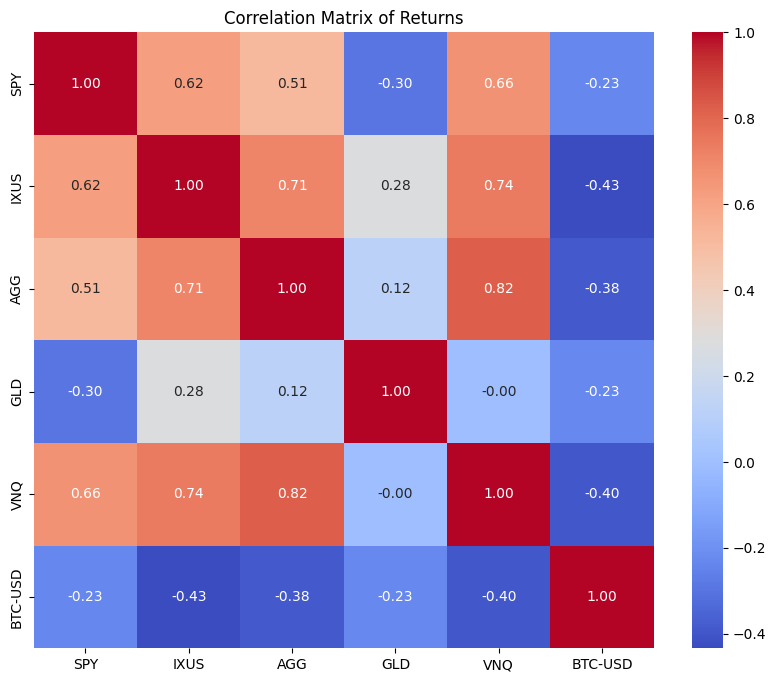

Correlation matrix visualized using a heatmap.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Returns')
plt.show()
print("Correlation matrix visualized using a heatmap.")

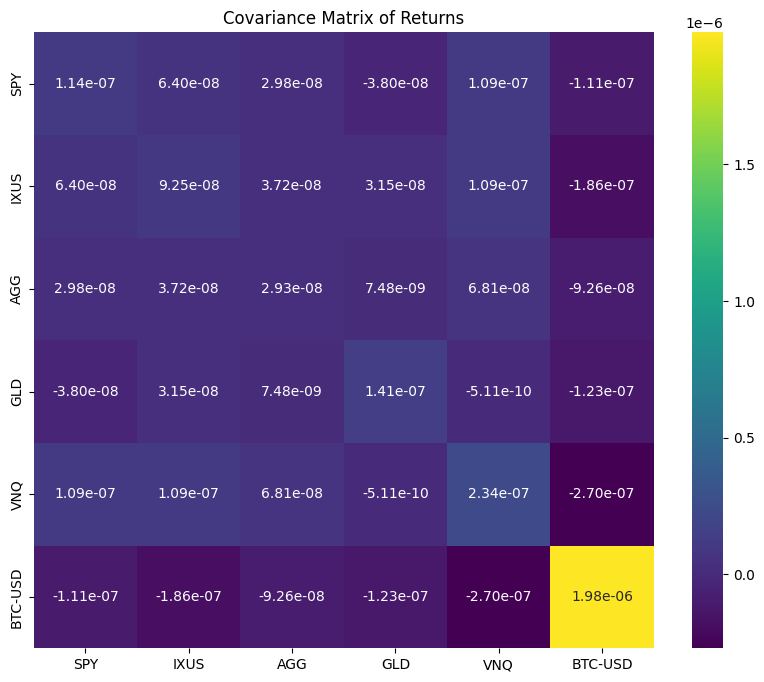

Covariance matrix visualized using a heatmap.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cov_matrix, annot=True, cmap='viridis', fmt=".2e")
plt.title('Covariance Matrix of Returns')
plt.show()
print("Covariance matrix visualized using a heatmap.")

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# -----------------------------
# 1. Load your data
# -----------------------------
# mu = expected annual returns (as decimals)
# cov = covariance matrix of returns (ANNUALIZED)

# Calculate actual expected annual returns from the 'returns' DataFrame
mu = returns.mean() * 12 # Annualize monthly returns

# Re-compute cov_matrix here to ensure it's the correct 6x6 matrix
# and convert to numpy array for optimization functions
cov = returns.cov().values

rf = 0.04     # risk-free rate
target_return = 0.12   # your chosen target return for Route 3

n = len(mu)
ones = np.ones(n)

# Get asset names from the original dataframe for labeling
asset_names = returns.columns.tolist()

# ----------------------------------------------------------------
# Helper: portfolio variance & return
# ----------------------------------------------------------------
def port_return(w):
    return w @ mu

def port_variance(w):
    return w.T @ cov @ w

def port_std(w):
    return np.sqrt(port_variance(w))

# ============================================
# -------------  ROUTE 1 ----------------------
#         MINIMUM VARIANCE PORTFOLIO
# ============================================

def solve_min_variance():
    w0 = ones / n

    # constraints: weights sum to 1
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

    # bounds: no negative weights (long-only portfolio)
    bounds = tuple((0,1) for _ in range(n))

    res = minimize(port_variance, w0, bounds=bounds, constraints=cons)
    return res.x

w_minvar = solve_min_variance()
print("Minimum Variance Weights:\n", w_minvar)

# ============================================
# -------------  ROUTE 2 ----------------------
#         MAXIMUM SHARPE RATIO PORTFOLIO
# ============================================

def negative_sharpe(w):
    return -(port_return(w) - rf) / port_std(w)

def solve_max_sharpe():
    w0 = ones / n

    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0,1) for _ in range(n))

    res = minimize(negative_sharpe, w0, bounds=bounds, constraints=cons)
    return res.x

w_maxsharpe = solve_max_sharpe()
print("Maximum Sharpe Ratio Weights:\n", w_maxsharpe)

# ============================================
# -------------  ROUTE 3 ----------------------
#         TARGET RETURN PORTFOLIO
#  (Lowest variance for a fixed target return)
# ============================================

def solve_target_return(target):
    w0 = ones / n

    cons = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: port_return(w) - target}
    )

    bounds = tuple((0,1) for _ in range(n))

    res = minimize(port_variance, w0, bounds=bounds, constraints=cons)
    return res.x

w_target = solve_target_return(target_return)
print("Target Return Portfolio Weights:\n", w_target)

Minimum Variance Weights:
 [1.76602132e-01 1.52361953e-01 2.82736508e-01 3.20393838e-01
 2.60208521e-18 6.79055685e-02]
Maximum Sharpe Ratio Weights:
 [4.53586779e-01 2.69025118e-14 1.24370322e-14 4.58223180e-01
 3.52497437e-14 8.81900405e-02]
Target Return Portfolio Weights:
 [7.64408175e-05 6.16809346e-04 9.37558126e-01 9.38062782e-04
 1.73472348e-17 6.08105612e-02]


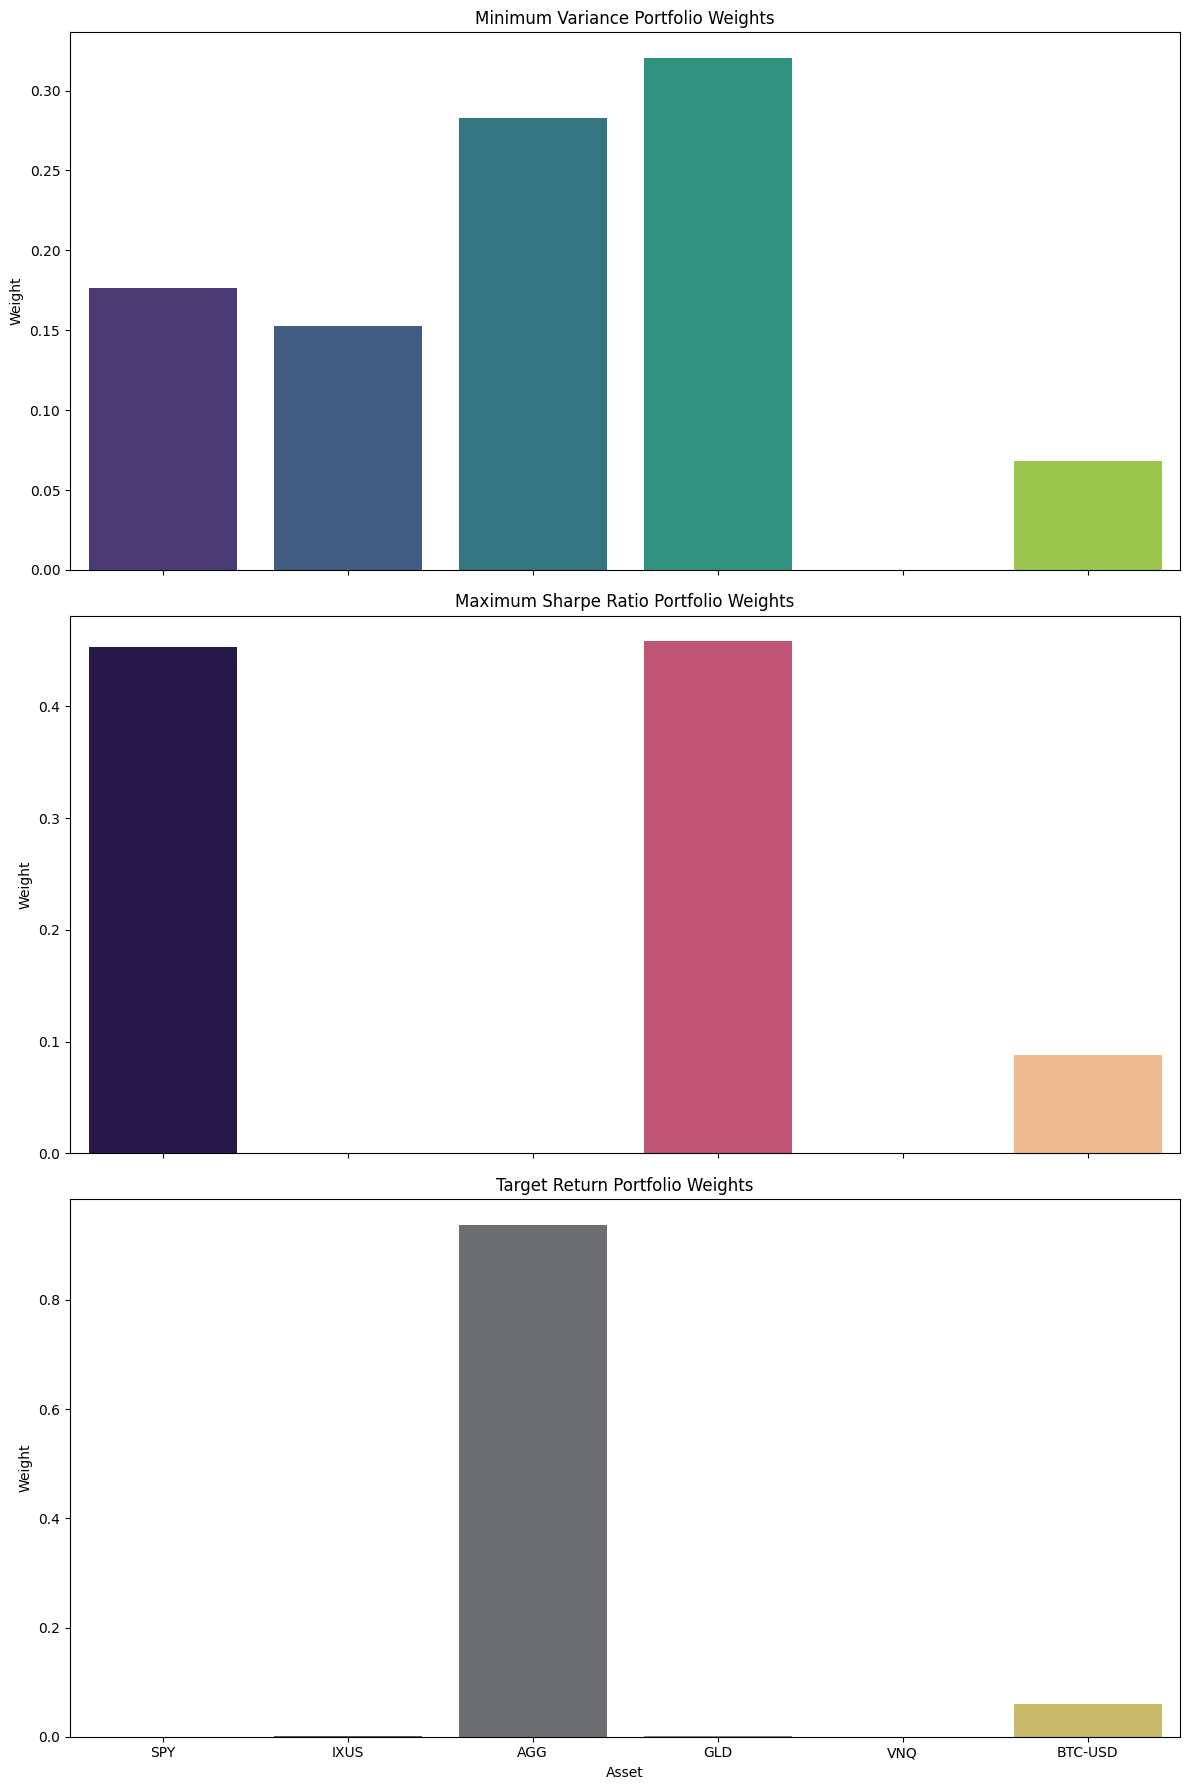

Portfolio weights visualized using bar charts for Minimum Variance, Maximum Sharpe Ratio, and Target Return portfolios.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get asset names from the original dataframe
asset_names = df.drop(columns=['Date']).columns

# Create a DataFrame to hold the portfolio weights for easier plotting
portfolio_weights_df = pd.DataFrame({
    'Asset': asset_names,
    'Min Variance': w_minvar,
    'Max Sharpe': w_maxsharpe,
    'Target Return': w_target
})

# Plotting the portfolio weights
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

sns.barplot(x='Asset', y='Min Variance', data=portfolio_weights_df, ax=axes[0], palette='viridis', hue='Asset', legend=False)
axes[0].set_title('Minimum Variance Portfolio Weights')
axes[0].set_ylabel('Weight')
axes[0].set_xlabel('Asset')

sns.barplot(x='Asset', y='Max Sharpe', data=portfolio_weights_df, ax=axes[1], palette='magma', hue='Asset', legend=False)
axes[1].set_title('Maximum Sharpe Ratio Portfolio Weights')
axes[1].set_ylabel('Weight')
axes[1].set_xlabel('Asset')

sns.barplot(x='Asset', y='Target Return', data=portfolio_weights_df, ax=axes[2], palette='cividis', hue='Asset', legend=False)
axes[2].set_title('Target Return Portfolio Weights')
axes[2].set_ylabel('Weight')
axes[2].set_xlabel('Asset')

plt.tight_layout()
plt.show()

print("Portfolio weights visualized using bar charts for Minimum Variance, Maximum Sharpe Ratio, and Target Return portfolios.")

In [ ]:
import numpy as np

# ============================================================
# SECTION 1 — Helper Functions
# ============================================================

def portfolio_return(weights, returns):
    """Expected portfolio return: wᵀμ"""
    return float(np.dot(weights, returns))

def portfolio_volatility(weights, cov_matrix):
    """Portfolio σ = sqrt(wᵀΣw)"""
    return float(np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))))

def portfolio_sharpe(weights, returns, cov_matrix, risk_free=0):
    """Sharpe Ratio = (Return − rf) / σ"""
    ret = portfolio_return(weights, returns)
    vol = portfolio_volatility(weights, cov_matrix)
    return (ret - risk_free) / vol

# ============================================================
# SECTION 2 — Insert Your Weights (from previous optimization)
# ============================================================

# Replace with your real weights from the optimization
weights_MVP = w_minvar
weights_MSR = w_maxsharpe
weights_Target = w_target

# ============================================================
# SECTION 3 — Insert Your Asset Data
# ============================================================

# Replace with your real expected returns (annualized)
expected_returns = mu.values # Use the 'mu' calculated from your data

# Re-compute cov_matrix here to ensure it's the correct 6x6 matrix
cov_matrix_eval = returns.cov().values # Use the 'cov_matrix' calculated from your data

risk_free_rate = rf   # Use the risk-free rate defined earlier

# ============================================================
# SECTION 4 — Evaluate Each Portfolio
# ============================================================

def evaluate_portfolio(name, weights):
    ret = portfolio_return(weights, expected_returns)
    vol = portfolio_volatility(weights, cov_matrix_eval)
    sharpe = portfolio_sharpe(weights, expected_returns, cov_matrix_eval, risk_free_rate)

    print(f"\n{name} Portfolio:")
    print(f"  Weights: {weights}")
    print(f"  Expected Return: {ret:.4f}")
    print(f"  Volatility (Risk): {vol:.4f}")
    print(f"  Sharpe Ratio: {sharpe:.4f}")

evaluate_portfolio("Minimum Variance", weights_MVP)
evaluate_portfolio("Maximum Sharpe Ratio", weights_MSR)
evaluate_portfolio("Target Return", weights_Target)

# ============================================================
# END
# ============================================================


Minimum Variance Portfolio:
  Weights: [1.76602132e-01 1.52361953e-01 2.82736508e-01 3.20393838e-01
 2.60208521e-18 6.79055685e-02]
  Expected Return: 0.2689
  Volatility (Risk): 0.0161
  Sharpe Ratio: 14.1795

Maximum Sharpe Ratio Portfolio:
  Weights: [4.53586779e-01 2.69025118e-14 1.24370322e-14 4.58223180e-01
 3.52497437e-14 8.81900405e-02]
  Expected Return: 0.3478
  Volatility (Risk): 0.0184
  Sharpe Ratio: 16.6835

Target Return Portfolio:
  Weights: [7.64408175e-05 6.16809346e-04 9.37558126e-01 9.38062782e-04
 1.73472348e-17 6.08105612e-02]
  Expected Return: 0.1200
  Volatility (Risk): 0.0150
  Sharpe Ratio: 5.3277


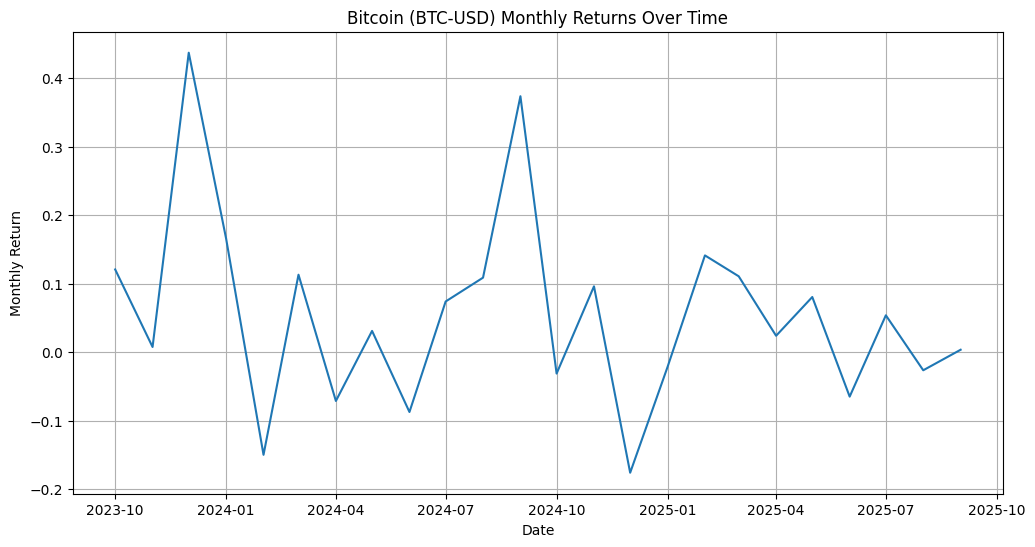

Bitcoin monthly returns visualized using a line plot.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='BTC-USD', data=df)
plt.title('Bitcoin (BTC-USD) Monthly Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.grid(True)
plt.show()
print("Bitcoin monthly returns visualized using a line plot.")